In [1]:
import os
import sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, cluster
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, Normalizer
sns.set(style="darkgrid")

In [2]:
%run clustering-methods.ipynb

In [3]:
minute_interval = 15
non_reoccuing_number = 100
document_features_name = "all-features"

In [4]:
ts_data = pd.read_csv(f"../../../data/corrected_data_{minute_interval}_{non_reoccuing_number}.csv")

In [5]:
ts_data['date'] = pd.to_datetime(ts_data['date'])
ts_data['ndt'] = pd.to_datetime(ts_data.date) + ts_data.hours.astype('timedelta64[h]') + ts_data.minutes.astype('timedelta64[m]')

In [6]:
features = pd.read_csv(f"../../../data/features_{minute_interval}_{non_reoccuing_number}.csv")
features['non-zero-ratio'] = features['non-zero-occurances'] / features['occurances']
features = features.fillna(0)

In [7]:
features_cl = features.drop(columns=['hash'])

In [8]:
global_date_range = pd.date_range(start=ts_data.date.min().date(), end=ts_data.date.max().date())

In [9]:
scaler = StandardScaler().fit(features_cl)
features_scaled = pd.DataFrame(scaler.transform(features_cl))
features_scaled.columns = features_cl.columns

In [10]:
normalizer = Normalizer().fit(features_cl)
features_normalized = pd.DataFrame(normalizer.transform(features_cl))
features_normalized.columns = features_cl.columns

In [11]:
s_normalizer = Normalizer().fit(features_scaled)
features_normalized_scaled = pd.DataFrame(normalizer.transform(features_scaled))
features_normalized_scaled.columns = features_cl.columns

In [12]:
linkage_methods = ["ward", "complete", "average", "single"]

# Features, scaling and normalizing #

In [13]:
features.describe()

non-zero-occurances    occurances          mean           std  \
count         13034.000000  13034.000000  13034.000000  13034.000000   
mean            225.608485   2272.715513      2.507927      8.271608   
std             425.488965   1647.628759     25.897775     19.639975   
min               2.000000      2.000000      0.024394      0.164784   
25%              87.000000    685.000000      0.173976      0.971559   
50%             152.000000   2050.000000      0.511554      2.742200   
75%             239.000000   3696.750000      1.311599      7.536027   
max            5084.000000   5084.000000   1842.358976    923.549541   

               skew            l1            l2            l3           c95  \
count  13034.000000  13034.000000  13034.000000  13034.000000  13034.000000   
mean      11.286901    133.550637    113.945057     97.514109      2.617845   
std        7.641661    275.115233    242.989916    213.165998     26.260446   
min       -5.366903      1.000000      1.000000      0.000000      0.024618   
25%        5.350773     15.000000     12.000000      9.000000      0.175160   
50%        9.702064     43.000000     33.000000     27.000000      0.517434   
75%       15.441165    130.000000    107.000000     90.750000      1.328891   
max       67.678576   7196.000000   6339.000000   6108.000000   1842.474206   

          above-c95  ...          ar_8         ar_12         ar_24  \
count  13034.000000  ...  1.303400e+04  1.303400e+04  1.303400e+04   
mean     100.329446  ... -1.952909e+05 -1.110693e+03 -9.707557e+01   
std      147.449492  ...  2.229474e+07  1.267342e+05  1.080645e+04   
min        0.000000  ... -2.545313e+09 -1.446874e+07 -1.233173e+06   
25%       39.000000  ... -2.625326e-02 -2.157215e-02 -1.126938e-02   
50%       68.000000  ... -5.174636e-04  0.000000e+00  0.000000e+00   
75%      109.000000  ...  2.712536e-02  2.518236e-02  1.670462e-02   
max     1734.000000  ...  3.384565e+04  2.716465e+04  4.779547e+03   

              ar_47     diff-mean      diff-std     diff-skew      lifespan  \
count  13034.000000  1.303400e+04  13034.000000  13034.000000  13034.000000   
mean       0.000466 -6.964039e-02      4.214002      1.225560     24.660887   
std        0.103774  2.554210e+00      9.974618      7.907841     17.156926   
min      -11.628392 -2.250000e+02      0.000000    -54.252160      1.000000   
25%       -0.003744 -2.266518e-02      0.824984     -0.860817      8.000000   
50%        0.000000 -4.196783e-03      1.697882      0.157653     22.000000   
75%        0.004694 -1.864052e-18      3.908630      3.061555     40.000000   
max        0.394763  3.850000e+01    298.327545     49.990659     54.000000   

                sum  non-zero-ratio  
count  1.303400e+04    13034.000000  
mean   4.649022e+03        0.159594  
std    1.259806e+05        0.179336  
min    1.000000e+02        0.001908  
25%    2.470000e+02        0.051390  
50%    6.120000e+02        0.091396  
75%    1.718958e+03        0.199045  
max    9.366553e+06        1.000000  

[8 rows x 26 columns]

In [14]:
data_forms = {'raw':features_cl, 'scaled':features_scaled, 'normalized':features_normalized, 'scalend and normalized':features_normalized_scaled}

In [15]:
fig =  plt.figure(constrained_layout=True)#plt.subplots(4, 2, constrained_layout=True)
fig.set_size_inches(24, 14)
gs = fig.add_gridspec(4, 7)
features_scale_1 = ['non-zero-occurances','occurances', 'above-c95'] # Features closer in scale
features_scale_2 = ['mean','std','skew','l1','l2','l3','c95','aic','bic',\
                    'ar_intercept','ar_0', 'ar_2', 'ar_4', 'ar_8', 'ar_12', 'ar_24', 'ar_47',\
                    'diff-mean','diff-std','diff-skew','non-zero-ratio']
ax_0_0 = fig.add_subplot(gs[0, 0])
ax_0_1 = fig.add_subplot(gs[0, 1:])
ax_0_1.set_title('Raw features')
sns.boxplot(data=features_cl[features_scale_1], palette="Set2", ax=ax_0_0)
sns.boxplot(data=features_cl[features_scale_2], palette="Set2", ax=ax_0_1)
ax_1_0 = fig.add_subplot(gs[1, 0])
ax_1_1 = fig.add_subplot(gs[1, 1:])
ax_1_1.set_title('Scaled features (value range)')
sns.boxplot(data=features_scaled[features_scale_1], palette="Set2", ax=ax_1_0)
sns.boxplot(data=features_scaled[features_scale_2], palette="Set2", ax=ax_1_1)
#ax_2_0 = fig.add_subplot(gs[2, 0])
ax_2 = fig.add_subplot(gs[2, 0:])
ax_2.set_title('Normalized features (distribution)')
#sns.boxplot(data=features_normalized[features_scale_1], palette="Set2", ax=ax_2_0)
sns.boxplot(data=features_normalized, palette="Set2", ax=ax_2)
#ax_3_0 = fig.add_subplot(gs[3, 0])
ax_3 = fig.add_subplot(gs[3, 0:])
ax_3.set_title('Scaled and normalized features (in that order)')
#sns.boxplot(data=features_normalized_scaled[features_scale_1], palette="Set2", ax=ax_3_0)
sns.boxplot(data=features_normalized_scaled, palette="Set2", ax=ax_3)

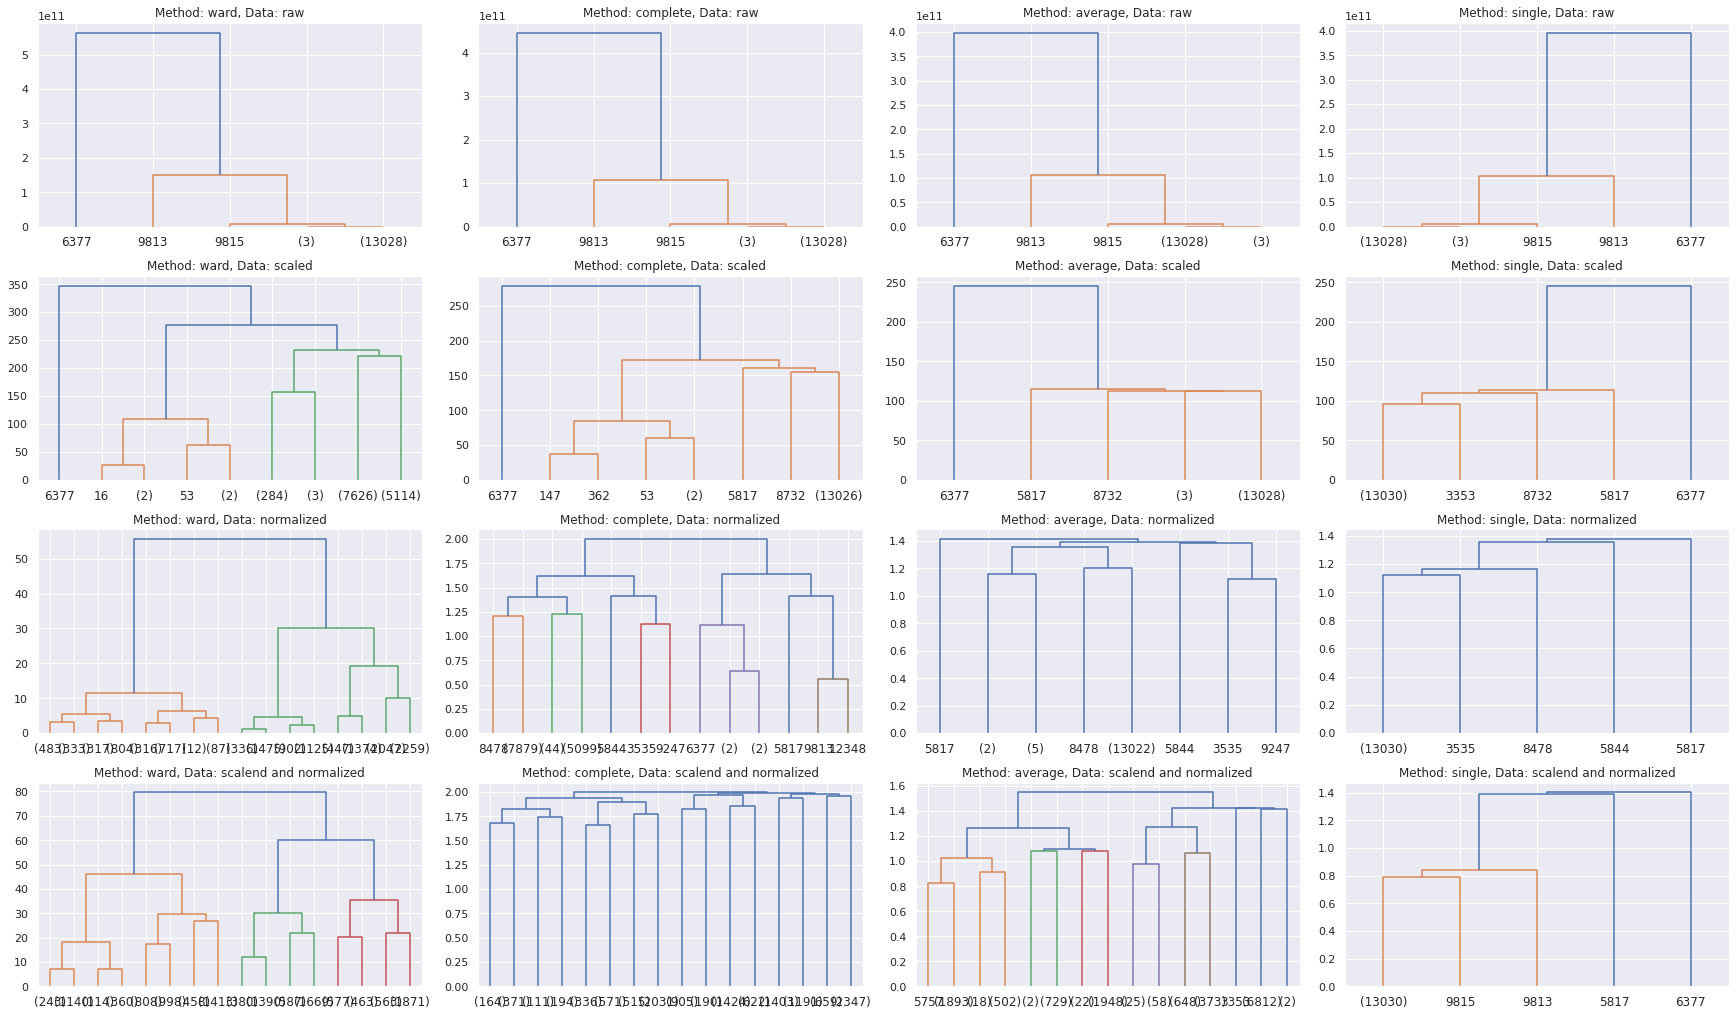

In [16]:
#models = {}
fig, ax = plt.subplots(len(data_forms), len(linkage_methods), constrained_layout=True)
fig.set_size_inches(24, 14)
for i, (key, f_data) in enumerate(data_forms.items()):
    for j, method in enumerate(linkage_methods):
        fitted_model = fit_model(f_data, method)
        model_dendogram(fitted_model, 3, ax=ax[i][j])
        ax[i][j].set_title(f'Method: {method}, Data: {key}')
        #models[f'{method}-{key}'] = fitted_model

The goal of clustering data in this thesis is to provide decent labelling. Ideally, we would like to be able to identify data by lifespan (interest in item spiking in days and dying off with time (possibly articles, discussion sections), or are consistently appearing through the dataset such as weather section or the main page).

Naively speaking, the ideal outcome would be clusters such as
* Long-living cluster (possibly news sections and title page, useful for forecasting sudden load increases)
* Short-living cluster (possibly articles or items related to articles, useful for forecasting article popularity)

It is unlikely we will get these clusters for free.

The data features come in quite a high dimension, it might be a good idea to look into reducing the dimensionality or selecting features manually.

It is not the goal of this thesis to compare clustering methods and this topic could be covered in much more depth, the goal is to find a satisfying method to label our data to continue onto forecasting.

Due to the amount of combinations possible and effort requiered to evalute individual clusters we will treat normalized and scaled data with priority, others will recieve less attention.

## Method: Single linkage

In [17]:
model_single = fit_model(features_cl, 'single', 4, None)
clusters_single = model_single.fit_predict(features_cl)
print(cluster_sizes(clusters_single))

[13031     1     1     1]


In [18]:
model_single_s = fit_model(features_scaled, 'single', 4, None)
clusters_single_s = model_single_s.fit_predict(features_scaled)
print(cluster_sizes(clusters_single_s))

[13031     1     1     1]


In [19]:
model_single_n = fit_model(features_normalized, 'single', 4, None)
clusters_single_n = model_single_n.fit_predict(features_normalized)
print(cluster_sizes(clusters_single_n))

[13031     1     1     1]


In [20]:
model_single_ns = fit_model(features_normalized_scaled, 'single', 4, None)
clusters_single_ns = model_single_ns.fit_predict(features_normalized_scaled)
print(cluster_sizes(clusters_single_ns))

[13031     1     1     1]


Single linkage method leads to clusters being built-up in a way that the last remaining clusters consist of all data + single remaining items.

It is unlikely to provide results we are looking for.

Other methods will require a much deeper look.

## Method: Average linkage

In [21]:
model_average = fit_model(features_cl, 'average', 4, None)
clusters_average = model_average.fit_predict(features_cl)
print(cluster_sizes(clusters_average))

[13031     1     1     1]


In [22]:
#plot_cluster_comparison(ts_data, features_cl, features, clusters_average)

In [23]:
model_average_s = fit_model(features_scaled, 'average', 4, None)
clusters_average_s = model_average_s.fit_predict(features_scaled)
print(cluster_sizes(clusters_average_s))

[13031     1     1     1]


In [24]:
model_average_n = fit_model(features_normalized, 'average', 4, None)
clusters_average_n = model_average_n.fit_predict(features_normalized)
print(cluster_sizes(clusters_average_n))

[13030     1     2     1]


In [25]:
model_average_sn = fit_model(features_normalized_scaled, 'average', 4, None)
clusters_average_sn = model_average_sn.fit_predict(features_normalized_scaled)
print(cluster_sizes(clusters_average_sn))

[6814 5115 1104    1]


In [26]:
plot_cluster_comparison(ts_data, features_normalized_scaled, features, clusters_average_sn)

## Method: Complete linkage

In [27]:
model_complete = fit_model(features_cl, 'complete', 4, None)
clusters_complete = model_complete.fit_predict(features_cl)
print(cluster_sizes(clusters_complete))

[13031     1     1     1]


In [28]:
#plot_cluster_comparison(ts_data, features_cl, features, clusters_complete)

In [29]:
model_complete_s = fit_model(features_scaled, 'complete', 4, None)
clusters_complete_s = model_complete_s.fit_predict(features_scaled)
print(cluster_sizes(clusters_complete_s))

[13027     1     5     1]


In [30]:
model_complete_n = fit_model(features_normalized, 'complete', 4, None)
clusters_complete_n = model_complete_n.fit_predict(features_normalized)
print(cluster_sizes(clusters_complete_n))

[    3     3     5 13023]


In [31]:
#plot_cluster_comparison(ts_data, features_normalized, features, clusters_complete_n)

In [32]:
model_complete_sn = fit_model(features_normalized_scaled, 'complete', 4, None)
clusters_complete_sn = model_complete_sn.fit_predict(features_normalized_scaled)
print(cluster_sizes(clusters_complete_sn))

[3141 4293 3006 2594]


In [33]:
plot_cluster_comparison(ts_data, features_normalized_scaled, features, clusters_complete_sn)

## Method: Ward linkage

In [34]:
model_ward = fit_model(features_cl, 'ward', 4, None)
clusters_ward = model_ward.fit_predict(features_cl)
print(cluster_sizes(clusters_ward))

[13031     1     1     1]


In [35]:
model_ward_s = fit_model(features_scaled, 'ward', 4, None)
clusters_ward_s = model_ward_s.fit_predict(features_scaled)
print(cluster_sizes(clusters_ward_s))

[12740   287     6     1]


In [36]:
plot_cluster_comparison(ts_data, features_scaled, features, clusters_ward_s)

In [37]:
model_ward_n = fit_model(features_normalized, 'ward', 4, None)
clusters_ward_n = model_ward.fit_predict(features_normalized)
print(cluster_sizes(clusters_ward_n))

[3069 4306 3838 1821]


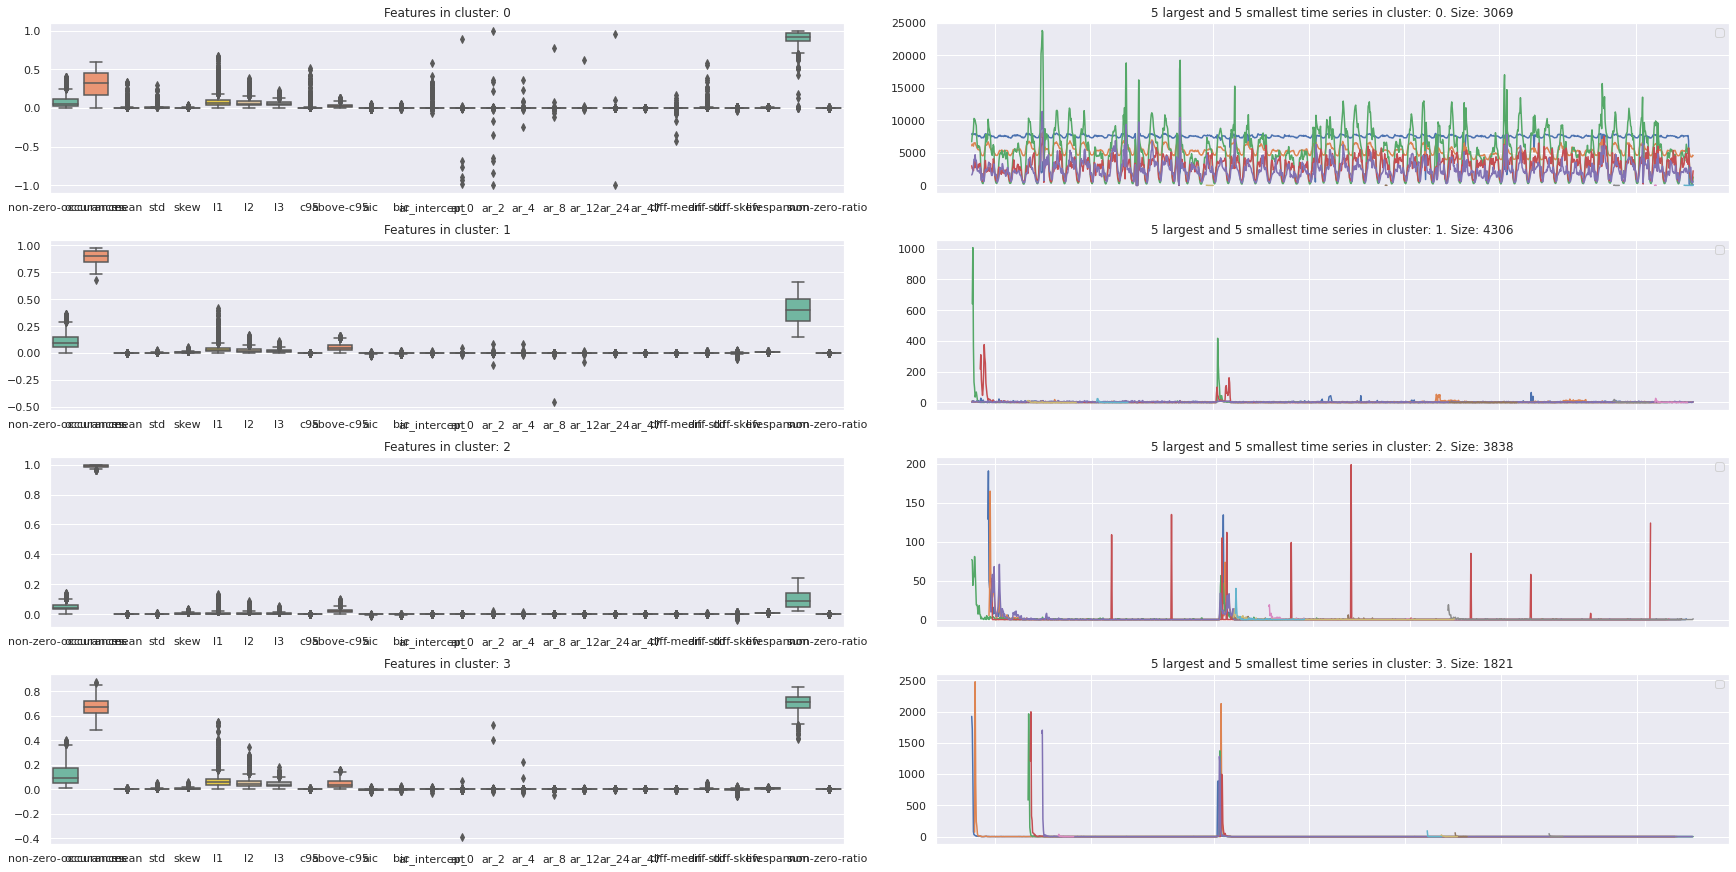

In [38]:
plot_cluster_comparison(ts_data, features_normalized, features, clusters_ward_n)

In [39]:
model_ward_sn = fit_model(features_normalized_scaled, 'ward', 4, None)
clusters_ward_sn = model_ward_sn.fit_predict(features_normalized_scaled)
print(cluster_sizes(clusters_ward_sn))

[3474 3677 4026 1857]


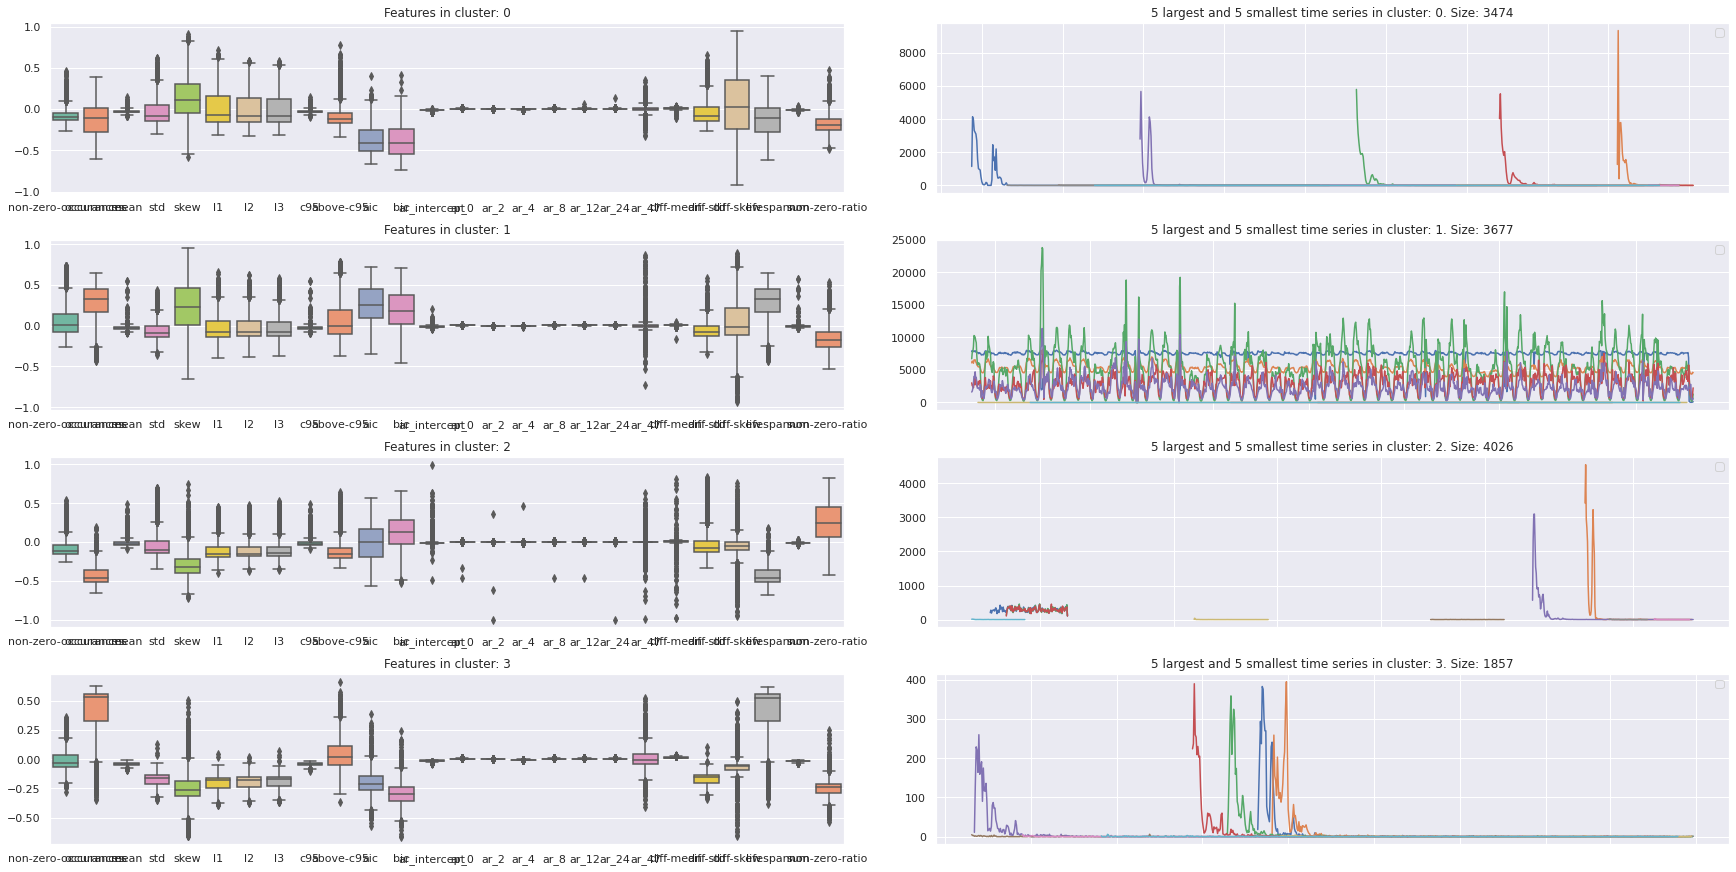

In [40]:
plot_cluster_comparison(ts_data, features_normalized_scaled, features, clusters_ward_sn)

## Evaluation

In [41]:
features['sn_c'] = clusters_complete_sn

In [42]:
cluster_evaluation = []
cluster_evaluation_data = []
cluster_group = 'sn_c'
n_clusters = 4

In [43]:
for cluster_id in range(0, n_clusters):
    group = pd.DataFrame(features.query(f'{cluster_group} == "{cluster_id}"'))
    cluster_evaluation.append(group)
    cluster_evaluation_data.append(ts_data[ts_data['hash'].isin(group['hash'])])

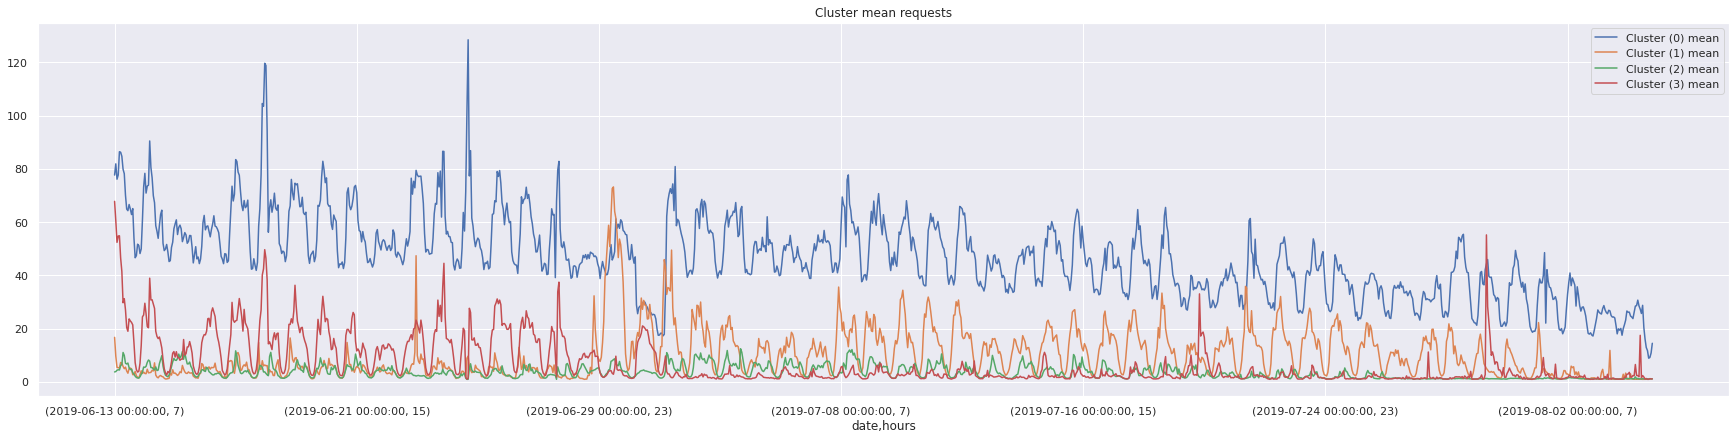

In [44]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches(24, 6)
for cluster_id in range(0, n_clusters):
    cluster_evaluation_data[cluster_id].groupby(['date','hours'])['count'].mean().plot(ax=ax, label=f"Cluster ({cluster_id}) mean")
ax.set_title("Cluster mean requests")
ax.legend()

In [45]:
barplot_cluster_lf = pd.DataFrame()
for cluster_id in range(0, n_clusters):
    barplot_cluster_lf[f'Cluster {cluster_id}'] = cluster_evaluation[cluster_id]['lifespan'].value_counts().sort_index().reindex(range(0, max(features['lifespan'].unique())), fill_value=0)

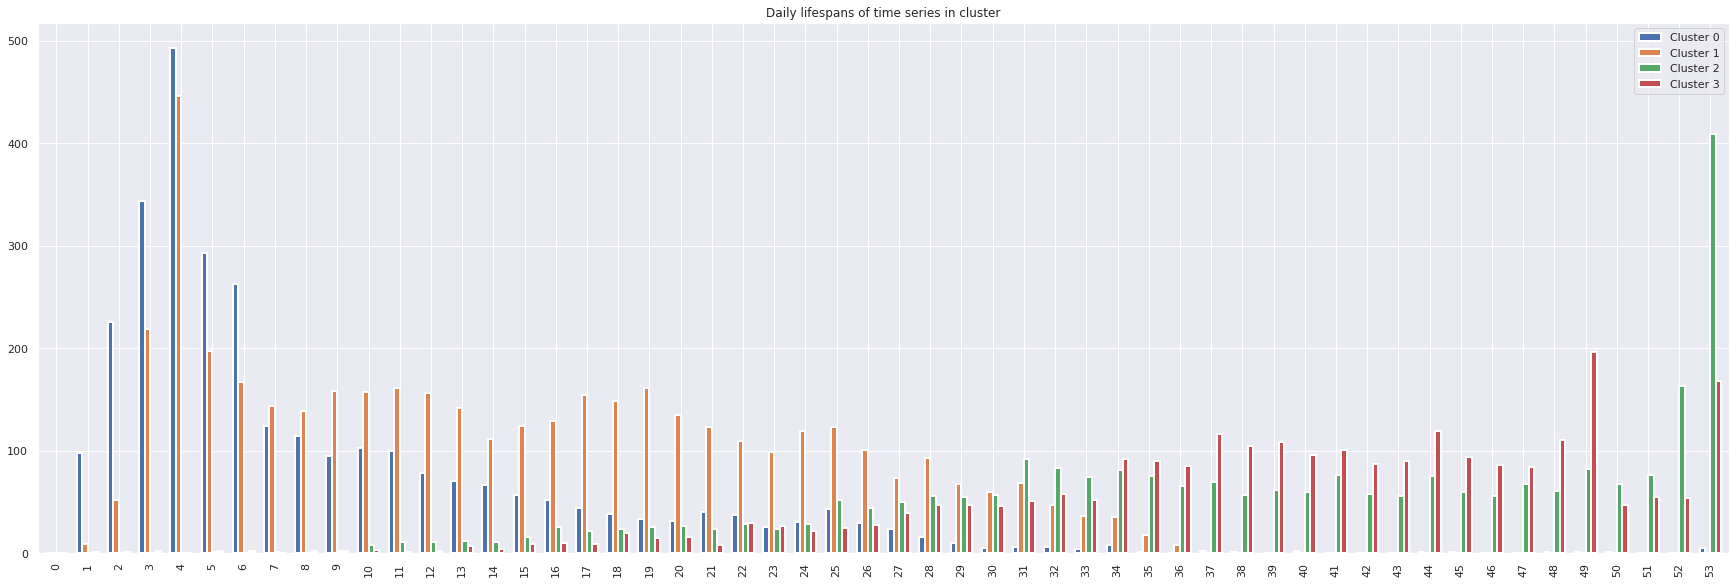

In [46]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches(24, 8)
ax.set_title("Daily lifespans of time series in cluster")
barplot_cluster_lf.plot(kind='bar',ax=ax, width=0.7, linewidth=2) #color=['r','b']
ax.legend()

In [47]:
ts_group = ts_data.drop(columns=['hours','minutes']).groupby(['hash','ndt']).sum()

In [48]:
# Disabled to prevent filling RAM
#for cluster_id in range(0, n_clusters):
#    plot_path = f"../../../plots/{document_features_name}/{cluster_group}-c{cluster_id}"
#    os.makedirs(plot_path)
#   plot_cluster(cluster_id, ts_group, cluster_evaluation[cluster_id].sort_values('sum'), plot_path)

In [49]:
#!tar -czf ../../plots/c0.tar ../../plots/
#!tar -czf ../../plots/c1.tar ../../plots/c1

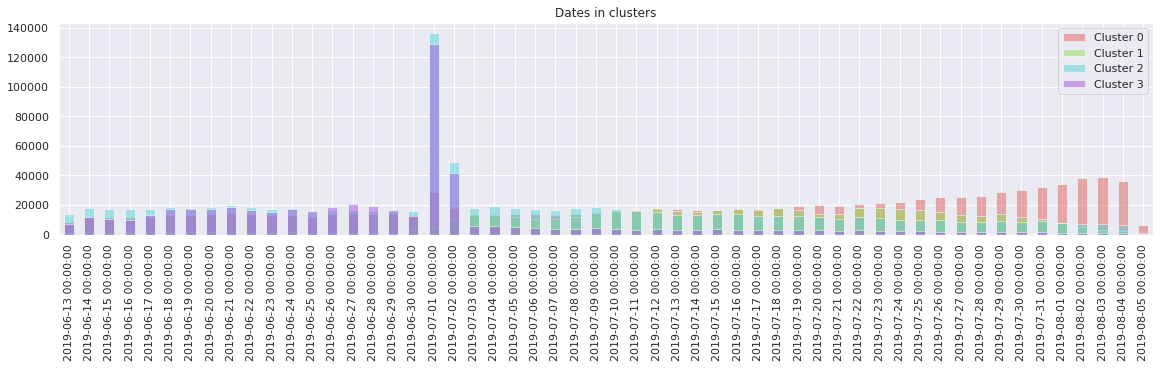

In [50]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches(16, 5)
ax.set_title("Dates in clusters")
for cluster_id in range(0, n_clusters):
    ts_data[ts_data['hash'].isin(cluster_evaluation[cluster_id]['hash'])]['date'].value_counts().sort_index()\
                           .plot(kind='bar', alpha=0.5, color=sns.color_palette("hls", n_clusters)[cluster_id], ax=ax, label=f'Cluster {cluster_id}')
ax.legend()